# MQ at BioASQ 6b

## Deep Learning and  Deep Reinforcement Learning for Query-based Multi-document Summarisation

Diego Molla-Aliod

LTG July 2018

# The BioASQ Challenge

![BioASQ](bioasq_logo.png) 

http://bioasq.org/

"A challenge on large-scale biomedical semantic indexing and question answering" 


# BioASQ Task 6a on Large-Scale Online Biomedical Semantic Indexing

In this task, the participants are asked to classify new PubMed documents, before PubMed curators annotate (in effect, classify) them manually. The classes come from the MeSH hierarchy. As new manual annotations become available, they are used to evaluate the classification performance of participating systems.



# BioASQ Task 6b on Biomedical Semantic QA (involves IR, QA, summarization and more)

This task uses benchmark datasets containing development and test questions, in English, along with gold standard (reference) answers constructed by a team of biomedical experts. The participants have to respond with 



* **Phase A:** relevant concepts, articles, snippets and RDF triples, from designated resources, 
* **Phase B:** exact and **'ideal' answers**.


# Timeline for Task 6b

![Timeline](task6b.png)

# Data for BioASQ 6b Phase B

In [9]:
import json
with open('BioASQ-trainingDataset6b.json') as f:
    jsondata = json.load(f)
len(jsondata['questions'])

2251

In [3]:
jsondata['questions'][0].keys()

dict_keys(['body', 'documents', 'ideal_answer', 'concepts', 'type', 'id', 'snippets'])

In [4]:
jsondata['questions'][0]['type']

'summary'

In [5]:
jsondata['questions'][0]['ideal_answer']

["Coding sequence mutations in RET, GDNF, EDNRB, EDN3, and SOX10 are involved in the development of Hirschsprung disease. The majority of these genes was shown to be related to Mendelian syndromic forms of Hirschsprung's disease, whereas the non-Mendelian inheritance of sporadic non-syndromic Hirschsprung disease proved to be complex; involvement of multiple loci was demonstrated in a multiplicative model."]

In [6]:
len(jsondata['questions'][0]['snippets'])

16

In [7]:
jsondata['questions'][0]['snippets'][0]

{'beginSection': 'abstract',
 'document': 'http://www.ncbi.nlm.nih.gov/pubmed/15829955',
 'endSection': 'abstract',
 'offsetInBeginSection': 131,
 'offsetInEndSection': 358,
 'text': 'Hirschsprung disease (HSCR) is a multifactorial, non-mendelian disorder in which rare high-penetrance coding sequence mutations in the receptor tyrosine kinase RET contribute to risk in combination with mutations at other genes'}

# Approach: General Framework

A **regression** system

1. Split the input text into candidate sentences.
2. Score each candidate sentence independently.
3. Return the $n$ sentences that have the highest score.

 . | Summary | Factoid | Yesno | List 
--- | --- | --- | --- | --- 
 $n$ | 6 | 2 | 2 | 3 

# General Architecture


In [1]:
%load_ext tikzmagic

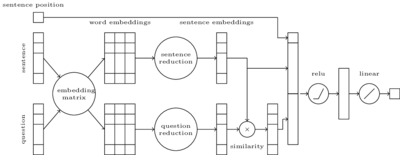

In [17]:
%%tikz --scale 0.3 -f png
\tiny
% input
    \draw (0,0) rectangle (1,5) (0,1) -- (1,1) (0,3) -- (1,3) (0,4) -- (1,4);
    \draw (0,-7) rectangle (1,-2) (0,-6) -- (1,-6) (0,-4) -- (1,-4) (0,-3) -- (1,-3);
    \draw (-1,2.5) node[rotate=90] {sentence};
    \draw (-1,-4.5) node[rotate=90] {question};

% word embeddings
    \draw (4,-1) node [circle,draw,align=center,text width=1cm] (em) {embedding matrix};
    \draw (8.5,6) node {word embeddings};
    \draw (7,0) rectangle (10,5) (7,1) -- (10,1) (7,3) -- (10,3) (7,4) -- (10,4) (8,0) -- (8,5) (9,0) -- (9,5);
    \draw (7,-7) rectangle (10,-2) (7,-6) -- (10,-6) (7,-4) -- (10,-4) (7,-3) -- (10,-3) (8,-7) -- (8,-2) (9,-7) -- (9,-2);

    \draw[->] (1,2.5) -- (em);
    \draw[->] (1,-4.5) -- (em);

    \draw[->] (em) -- (7,2.5);
    \draw[->] (em) -- (7,-4.5);
% sentence embeddings
    \draw (14,2.5) node [circle,draw,align=center,text width=1cm] (sr) {sentence reduction};
    \draw (14,-4.5) node [circle,draw,align=center,text width=1cm] (qr) {question reduction};
    \draw (18,6) node {sentence embeddings};
    \draw (18,0) rectangle (19,5) (18,1) -- (19,1) (18,3) -- (19,3) (18,4) -- (19,4);
    \draw (18,-7) rectangle (19,-2) (18,-6) -- (19,-6) (18,-4) -- (19,-4) (18,-3) -- (19,-3);

    \draw[->] (10,2.5) -- (sr);
    \draw[->] (sr) -- (18,2.5);
    \draw[->] (10,-4.5) -- (qr);
    \draw[->] (qr) -- (18,-4.5);

% similarity
    \draw (21,-4.5) node [circle,draw] (t) {$\times$};
    \draw (23,-7) rectangle (24,-2) (23,-6) -- (24,-6) (23,-4) -- (24,-4) (23,-3) -- (24,-3);

    \draw[->] (19,2.5) -| (t);
    \draw[->] (19,-4.5) -- (t);

    \draw[->] (21,2.5) |- (25,1.5);
    \draw[->] (t) -- (23,-4.5);
    \draw (24,-4.5) -| (24.5,-3.5);
    \draw[->] (24.5,-3.5) -- (25,-3.5);

    \draw (21,-6.2) node {similarity};

% hidden layer
    \draw (25,-1) rectangle (26,4);
    \draw (25,-1) rectangle (26,-6);
    \draw (28,-1) circle[radius=1] (27.5,-1.5) -- (28,-1.5) -- (28.5,-0.5);
    \draw (28,1) node {relu};

    \draw (30,-3.5) rectangle (31,1.5);

    \draw[->] (26.2,-1) -- (27,-1);
    \draw[->] (29,-1) -- (30,-1);

% final layer
    \draw (33,-1) circle[radius=1] (32.5,-1.5) -- (33.5,-0.5);
    \draw (35,-1.5) rectangle (36,-0.5);
    \draw (33,1) node {linear};

    \draw[->] (31,-1) -- (32,-1);
    \draw[->] (34,-1) -- (35,-1);
    
% position
    \draw (0,6) rectangle (1,7);
    \draw (1,6.5) -- (24,6.5);
    \draw[->] (24,6.5) |- (25,4.5);
    \draw (25,5) rectangle (26,4);
    \draw (0,7.7) node {sentence position};

![architecture](architecture.png)

# Sentence and Question Reduction

# NNR Mean

$$
s_i = \sum_{j=1}^{n_i}m_j
$$

# NNR LSTM

$$
s_i  = \left[\overrightarrow{h}_{n_i};\overleftarrow{h}_1\right]
$$

$$
\begin{array}{cc}
\begin{array}{rcl}
\overrightarrow{c}_t & = & \overrightarrow{f} \odot \overrightarrow{c}_{t+1} + \overrightarrow{i} \odot \overrightarrow{z}\\
\overrightarrow{h}_t & = & \overrightarrow{o} \odot \tanh(\overrightarrow{c}_t)\\
\overrightarrow{i} & = & \sigma(\overrightarrow{W}_{i}\cdot m_t + \overrightarrow{U}_{i}\cdot \overrightarrow{h}_{t+1} + \overrightarrow{b}_i)\\
\overrightarrow{f} & = & \sigma(\overrightarrow{W}_{f}\cdot m_t + \overrightarrow{U}_{f}\cdot \overrightarrow{h}_{t+1} + \overrightarrow{b}_f)\\
\overrightarrow{o} & = & \sigma(\overrightarrow{W}_{o}\cdot m_t + \overrightarrow{U}_{o}\cdot \overrightarrow{h}_{t+1} + \overrightarrow{b}_o)\\
\overrightarrow{z} & = & \tanh(\overrightarrow{W}_{z}\cdot m_t + \overrightarrow{U}_{z}\cdot \overrightarrow{h}_{t+1} + \overrightarrow{b}_z)\\
\end{array}
&
\begin{array}{rcl}
\overleftarrow{c}_t & = & \overleftarrow{f} \odot \overleftarrow{c}_{t+1} + \overleftarrow{i} \odot \overleftarrow{z}\\
\overleftarrow{h}_t & = & \overleftarrow{o} \odot \tanh(\overleftarrow{c}_t)\\
\overleftarrow{i} & = & \sigma(\overleftarrow{W}_{i}\cdot m_t + \overleftarrow{U}_{i}\cdot \overleftarrow{h}_{t+1} + \overleftarrow{b}_i)\\
\overleftarrow{f} & = & \sigma(\overleftarrow{W}_{f}\cdot m_t + \overleftarrow{U}_{f}\cdot \overleftarrow{h}_{t+1} + \overleftarrow{b}_f)\\
\overleftarrow{o} & = & \sigma(\overleftarrow{W}_{o}\cdot m_t + \overleftarrow{U}_{o}\cdot \overleftarrow{h}_{t+1} + \overleftarrow{b}_o)\\
\overleftarrow{z} & = & \tanh(\overleftarrow{W}_{z}\cdot m_t + \overleftarrow{U}_{z}\cdot \overleftarrow{h}_{t+1} + \overleftarrow{b}_z)\\
\end{array}
\end{array}
$$

# NNR Results


In [18]:
def my_barplot(ax):
    # The following code is based on http://robertmitchellv.com/blog-bar-chart-annotations-pandas-mpl.html
    ax.set_yticks([0, 0.05, 0.1, 0.15, 0.2, 0.25, 0.3])

    # create a list to collect the plt.patches data
    totals = []

    # find the values and append to list
    for i in ax.patches:
        totals.append(i.get_height())

    # set individual bar lables using above list
    total = sum(totals)

    # set individual bar lables using above list
    for i in ax.patches:
        # get_x pulls left or right; get_height pushes up or down
        ax.text(i.get_x()-.03, i.get_height()+0.017, \
                str(round(i.get_height(), 3)))

In [19]:
%matplotlib inline
import pandas as pd
methods = pd.Index(["firstn", "random", "cos_lsa", "cos_embeddings",
                   "svr", "nnr_mean", "nnr_lstm"])
data = pd.DataFrame(index=methods)
data['su4mean'] = [0.23674, 0.18799, 0.18703, 0.19395,
                  0.23063, 0.237760,  0.244691]
data['su4stdev'] = [0.00465, 0.00740, 0.01279, 0.01396,
                   0.00734,  0.004805, 0.007900]

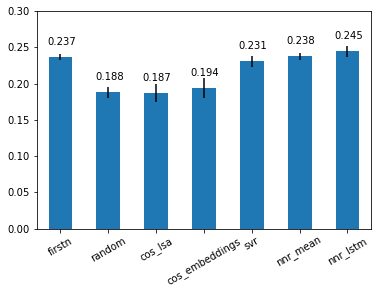

In [20]:
my_barplot(data['su4mean'].plot.bar(yerr=data['su4stdev'], rot=30))

# Towards Reinforcement Learning

* **Oracle 1:** Return the $n$ snippets with highest *individual* ROUGE.
  * An upper bound of our NNR framework.
* **Oracle 2:** Return the $n$ snippets with highest *collective* ROUGE.
  * An upper bound of extractive summarisers.

In [22]:
%matplotlib inline
import csv
from matplotlib import pyplot as plt
o1 = []
o2 = []
dataFilename = "oracles_results.csv"
with open(dataFilename, 'r') as f:
    reader = csv.DictReader(f)
    for i, line in enumerate(reader):
        r1 = float(line['oracle1SU4'])
        r2 = float(line['oracle2SU4'])
        if line['oracle2Summary'] == '':
            continue
        if r1 > r2:
            print("%i: %.5f > %.5f" % (i, r1, r2))
            continue
        o1.append(r1)
        o2.append(r2)

In [23]:
def two_plots(o1, o2):
    plt.figure(figsize=(12,4))

    plt.subplot(131)
    plt.plot([0,1],[0,1], color="red")
    plt.scatter(o2, o1, alpha=0.3)
    plt.xlabel("Oracle 2")
    plt.ylabel("Oracle 1")
    plt.title("Scatterplot of %i questions" % len(o1))

    plt.subplot(132)
    plt.boxplot([o1, o2], labels=['Oracle 1', 'Oracle 2'])
    plt.ylim(ymin=0)
    plt.title("Box plot of %i questions" % len(o1))

    #plt.subplot(133)
    violin = plt.violinplot([o1, o2], [1, 2], showmeans=True)
    plt.ylim(ymin=0)
    labels = ['Oracle 1', 'Oracle 2']
    #plt.xticks(np.arange(1, len(labels) + 1))
    plt.xticks([1, 2],labels)
    plt.title("Violin  and box plot of %i questions" % len(o1))

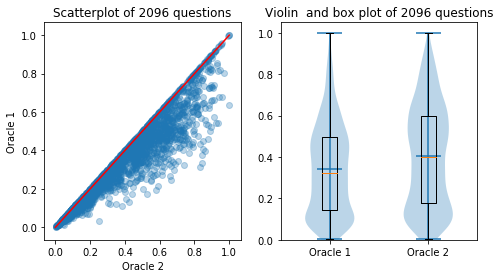

In [24]:
two_plots(o1, o2)

# Using Reinforcement Learning

* Global policy
  * Neural net to implement the global policy
  * Learn policy on training set
  * Evaluate policy on test set
* Train policy using REINFORCE
  * Variant without using baseline

# The Global Policy

$$
\begin{array}{rcl}
Pr(a=0;\theta) & = & \sigma(W_hh + b_h)\\
h & = & \max(0, W_ss + b_s)  
\end{array}
$$
where $\theta = \left[W_h;W_s;b_h;b_s\right]$ and the input $h$ is the concatenation of the following features:

1. *tf.idf* of candidate sentence $i$;
2. *tf.idf* of the entire input text to summarise;
3. *tf.idf* of the summary generated so far;
4. *tf.idf* of the candidate sentences that are yet to be processed;
5. *tf.idf* of the question; and
6. Length (in number of sentences) of the summary generated so far.

# Comparing the Python and the Perl versions of ROUGE

In [26]:
import pandas as pd
rouge_data = pd.read_csv('compare_rouge.csv')
sampled_rouge_data = rouge_data.sample(n=5000, replace=False)

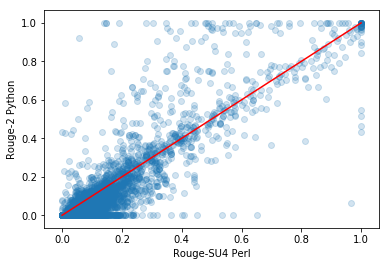

In [34]:
%matplotlib inline
from matplotlib import pyplot as plt
plt.scatter(sampled_rouge_data['rouge-SU4-perl'], sampled_rouge_data['rouge-2-python'], alpha=0.2)
plt.plot([0,1], [0,1], color="red")
plt.xlabel("Rouge-SU4 Perl")
ax = plt.ylabel("Rouge-2 Python")

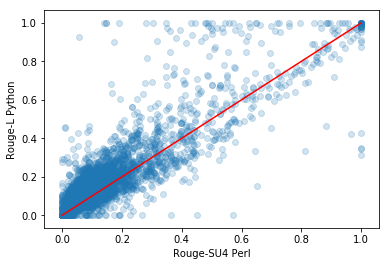

In [33]:
plt.scatter(sampled_rouge_data['rouge-SU4-perl'], sampled_rouge_data['rouge-L-python'], alpha=0.2)
plt.plot([0,1], [0,1], color="red")
plt.xlabel("Rouge-SU4 Perl")
ax = plt.ylabel("Rouge-L Python")

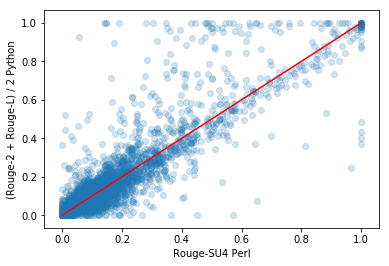

In [32]:
plt.scatter(sampled_rouge_data['rouge-SU4-perl'], (sampled_rouge_data['rouge-L-python']+sampled_rouge_data['rouge-2-python'])/2, alpha=0.2)
plt.plot([0,1], [0,1], color="red")
plt.xlabel("Rouge-SU4 Perl")
ax = plt.ylabel("(Rouge-2 + Rouge-L) / 2 Python")

# Final Runs

* **MQ-1:** Return the first $n$ sentences. This is the Firstn baseline. 
* **MQ-2:** Return the $n$ sentences with highest cosine similarity with the question. This is the Cos Embeddings baseline.
* **MQ-3:** Return the $n$ sentences according to the SVR baseline.
* **MQ-4:** Score the sentences using the LSTM-based deep learning approach.
* **MQ-5:** Apply reinforcement learning.

In [30]:
%matplotlib inline
import pandas as pd
batches = pd.Index(['Batch 1', 'Batch 2', 'Batch 3', 'Batch 4', 'Batch 5'])
RUN = "RUN-%i"
#RUN = "MQ-%i"
bioasq_data = pd.DataFrame(index=batches)
bioasq_data[RUN % 1] = [0.4319, 0.4660, 0.4251, 0.4930, 0.5259]
bioasq_data[RUN % 2] = [0.5181, 0.4762, 0.4296, 0.5166, 0.5569]
bioasq_data[RUN % 3] = [0.4958, 0.5064, 0.4733, 0.5071, 0.5718]
bioasq_data[RUN % 4] = [0.5168, 0.5297, 0.4885, 0.5495, 0.5996]
bioasq_data[RUN % 5] = [0.3585, 0.3981, 0.3582, 0.4432, 0.4539]

bioasq_data

,RUN-1,RUN-2,RUN-3,RUN-4,RUN-5
Batch 1,0.4319,0.5181,0.4958,0.5168,0.3585
Batch 2,0.4660,0.4762,0.5064,0.5297,0.3981
Batch 3,0.4251,0.4296,0.4733,0.4885,0.3582
Batch 4,0.4930,0.5166,0.5071,0.5495,0.4432
Batch 5,0.5259,0.5569,0.5718,0.5996,0.4539


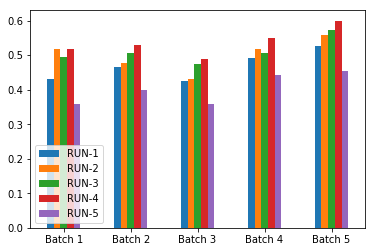

In [31]:
ax = bioasq_data.plot.bar(rot=0, legend=False).legend(loc='lower left')

# RL for batch 1

![rl-1](rl-1.png)

# RL for batch 2

![rl-2](rl-2.png)

# RL for batches 3 to 5

![rl-3-5](rl-3-5.png)

# Conclusions

* Deep learning was best.
* Position features help.
* Reinforcement learning promising.
   * For some reason, big discrepancy of RL results in final submission.

# Further Work

* Introduce baselines in the REINFORCE algorithm.
* Try more sophisticated global policy models.